In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
# load age productivity profile and lifetable
age_profile = np.loadtxt('ageprod.txt')
age_profile = age_profile / np.mean(age_profile)
surv_rate = np.loadtxt('surv_rate.txt')

In [3]:
# economic parameters
maxage = 81
ret_age = 45
irate = 0.03
time_pref = irate
betta = 1.0 / (1.0 + time_pref)
sigma = 2.0
tau = 0.15
ben = 0.44
v_frisch = 1.0
chi = 12.0

In [4]:
amin = 0.0
amax = 50.0
na = 101

# set up the savings grid
agrid = np.linspace(amin, amax, na)

In [5]:
# set up the income stream
y = np.zeros(maxage)
y[:ret_age] = 3 * (1 - tau) * age_profile
y[ret_age:] = ben

In [6]:
# pre-allocate
ap = np.zeros((maxage, na))
con = np.zeros((maxage, na))
lab = np.zeros((maxage, na))
lab_new = np.zeros((maxage, na))
c_new = np.zeros((maxage, na)) # implied consumption
astar = np.zeros((maxage, na)) # endogenous asset
a_bar = np.zeros(maxage) # a today correspodning to a'=0

In [7]:
# LAST PERIOD
j = maxage-1
# loop over (beginning-of-period) savings
for ia in range(na):
    # the household will consume all the remaining resources
    ap[j, ia] = 0.0
    con[j, ia] = (1.0 + irate) * agrid[ia] + y[j]

In [8]:
# RETRIEMENT PERIODS
# loop backwards over all periods
for j in range(maxage-2, ret_age-1, -1):

    # EGM Step 1:
    # loop over savings choice
    for ia in range(na):
        # compute the RHS of the euler equation
        rhs = betta * surv_rate[j] * (1.0 + irate) * con[j+1, ia]**(-sigma)
        # compute the implied consumption
        c_new[j, ia] = rhs**(-1.0/sigma)
        # compute the implied beginning-of-period assets
        astar[j, ia] = (c_new[j, ia] + agrid[ia] - y[j]) / (1.0 + irate)

    # store the savings corresponding to the lowest grid point
    a_bar[j] = astar[j, 0]

    # EGM Step 2:
    # loop over beginning-of-period assets
    for ia in range(na):
        if agrid[ia] < a_bar[j]: # if the borrowing constraint is binding
            con[j, ia] = y[j] + (1.0 + irate) * agrid[ia]
            ap[j, ia] = 0.0
        else: # if the borrowing cosntraint is not binding
            con[j, ia] = np.interp(agrid[ia], astar[j, :], c_new[j, :])
            ap[j, ia] = (1.0 + irate) * agrid[ia] + y[j] - con[j, ia]

In [9]:
# WORKING PERIODS
# loop backwards over all periods
for j in range(ret_age-1, -1, -1):

    # EGM Step 1:
    # loop over savings choice
    for ia in range(na):
        # compute the RHS of the euler equation
        rhs = betta * surv_rate[j] * (1.0 + irate) * con[j+1, ia]**(-sigma)
        # compute the implied consumption
        c_new[j, ia] = rhs**(-1.0/sigma)
        # find labor supply
        lab_new[j, ia] = ((c_new[j, ia] ** (-sigma) * y[j]) / chi) ** v_frisch
        # compute the implied beginning-of-period assets
        astar[j, ia] = (c_new[j, ia] + agrid[ia] - y[j] * lab_new[j, ia]) / (1.0 + irate)

    # store the savings corresponding to the lowest grid point
    a_bar[j] = astar[j, 0]

    # EGM Step 2:
    # loop over beginning-of-period assets
    for ia in range(na):
        if agrid[ia] < a_bar[j]: # if the borrowing constraint is binding

            # when the constraint is binding the choices for consumption and
            # labor supply are not analytical, therefore we solve the system
            # of equations numerically
            def lab_bc(lab_guess):
                con_imp = (1 + irate) * agrid[ia] + y[j] * lab_guess
                res = chi * lab_guess ** (1 / v_frisch) - y[j] * con_imp ** (-sigma)
                return res

            lab[j, ia] = scipy.optimize.brentq(lab_bc, 0.01, 2.0)
            con[j, ia] = y[j] * lab[j, ia] + (1.0 + irate) * agrid[ia]
            ap[j, ia] = 0.0
        else: # if the borrowing cosntraint is not binding

            con[j, ia] = np.interp(agrid[ia], astar[j, :], c_new[j, :])
            lab[j, ia] = np.interp(agrid[ia], astar[j, :], lab_new[j, :])
            ap[j, ia] = (1.0 + irate) * agrid[ia] + y[j] * lab[j, ia] - con[j, ia]

In [10]:
# LIFECYCLE PROFILES
a_profile = np.zeros(maxage)
con_profile = np.zeros(maxage)
ap_profile = np.zeros(maxage)
lab_profile = np.zeros(maxage)

for j in range(maxage-1):
    con_profile[j] = np.interp(a_profile[j], agrid, con[j, :])
    ap_profile[j] = np.interp(a_profile[j], agrid, ap[j, :])
    a_profile[j+1] = ap_profile[j]
    lab_profile[j] = np.interp(a_profile[j], agrid, lab[j, :])

# last period
con_profile[maxage-1] = np.interp(a_profile[maxage-1], agrid, con[maxage-1, :])
lab_profile[maxage-1] = np.interp(a_profile[maxage-1], agrid, lab[maxage-1, :])

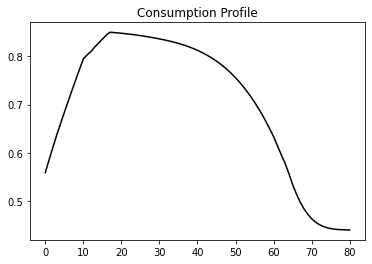

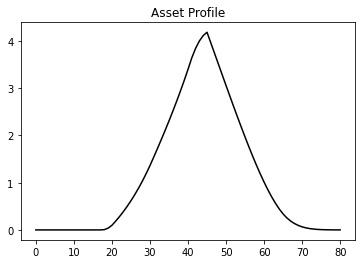

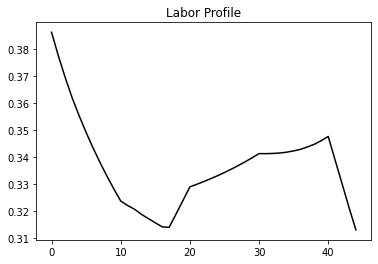

In [11]:
plt.figure()
plt.plot(np.arange(maxage), con_profile, color='black')
plt.title('Consumption Profile')

plt.figure()
plt.plot(np.arange(maxage), a_profile, color='black')
plt.title('Asset Profile')

plt.figure()
plt.plot(np.arange(ret_age), lab_profile[:ret_age], color='black')
plt.title('Labor Profile')

plt.show()